(c_rasters)=
 
----------------

```{admonition} Learning Objectives
* Create new raster objects 
* Assign the correct projection or CRS
```
```{admonition} Review
* [Please review Affine transformation](d_affine.md)
```
----------------

# Spatial Raster Data in Python
A raster data model uses an array of cells, or pixels, to represent real-world objects. Raster datasets are commonly used for representing and managing imagery, surface temperatures, digital elevation models, and numerous other entities. A raster can be thought of as a special case of an area object where the area is divided into a regular grid of cells. But a regularly spaced array of marked points may be a better analogy since rasters are stored as an array of values where each cell is defined by a single coordinate pair inside of most GIS environments. Implicit in a raster data model is a value associated with each cell or pixel. This is in contrast to a vector model that may or may not have a value associated with the geometric primitive.

In order to work with raster data we will be using `rasterio` and later `geowombat`. Behind the scenes a `numpy.ndarray` does all the heavy lifting. To understand how raster works it helps to construct one from scratch. 

Here we create two `ndarray` objects one `X` spans [-90&deg;,90&deg;] longitude, and `Y` covers [-90&deg;,90&deg;] latitude.

In [1]:
import numpy as np
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)
X

array([[-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.],
       [-90., -54., -18.,  18.,  54.,  90.]])

Let's generate some data representing temperature and store it an array `Z`

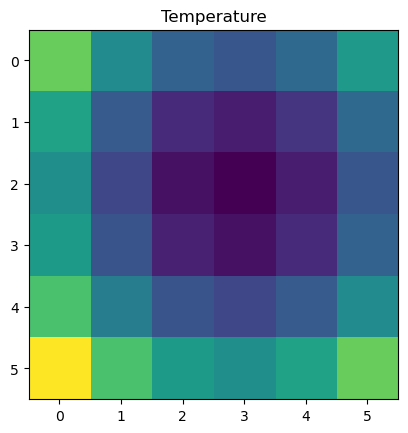

In [2]:
import matplotlib.pyplot as plt

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

Note that *`Z` contains no data on its location*. Its just an array, the information stored in `x` and `y` aren't associated with it at all. This location data will often be stored in the header of file. In order to 'locate' the array on the map we will use affine transformations. 



## Assigning spatial data to an array in python
Ok we have an array of data and some coordinates for each cell, but how do we create a spatial dataset from it? In order to do this we need three components:

1) An array of data and typically the xy coordinates
2) A coordinate reference system which defines what coordinate space we are using (e.g. degrees or meters, where is the prime meridian etc)
3) A transform defining the coordinate of the upper left hand corner and the cell resolution

```{note}
These topic is covered extensively in the next chapter. We will briefly introduce the topic here, but will go into the details later. 

- For more info on transforms go [here](d_raster_crs_intro.md). 
- For more info on coordinate references systems go [here](d_crs_what_is_it.md) 
- or to understand CRS codes go [here](d_understand_crs_codes). 
- To help bring it all together, read/writing rasters go to [Reading & Writing Rasters with Rasterio](e_new_rasters).
```

Once you have those components you can write out a working spatial raster dataset in python in a few lines of code. We just need to provide the information listed above in a format that rasterio understands.

In [4]:
from rasterio.transform import Affine
import rasterio as rio

res = (x[-1] - x[0]) / 240.0
transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)

# open in 'write' mode, unpack profile info to dst
with rio.open(
    "../../pygis/temp/new_raster.tif",
    "w",
    driver="GTiff",         # output file type
    height=Z.shape[0],      # shape of array
    width=Z.shape[1],
    count=1,                # number of bands
    dtype=Z.dtype,          # output datatype
    crs="+proj=latlong",    # CRS
    transform=transform,    # location and resolution of upper left cell
) as dst:
    # check for number of bands
    if dst.count == 1:
        # write single band
        dst.write(Z, 1)
    else:
        # write each band individually
        for band in range(len(Z)):
            # write data, band # (starting from 1)
            dst.write(Z[band], band + 1)

```{note}
Raster data is often 'multiband' (e.g. red, green, blue), so I provided code that works for both multiband and single band data. 

If you are storing multiband data the dimensions should be stored as (band, y, x ).

Read more about this here: [Reading & Writing Rasters with Rasterio](e_new_rasters)
```